In [4]:
using DataFrames, CSV
using Base.Threads

train = CSV.read("train.csv", DataFrame)
label = train[:, 1]
image = [collect(values(train[i, 2:end])) / 255 for i in 1:size(train)[1]]

println(typeof(image))
display(image[1])

784-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

Vector{Vector{Float64}}


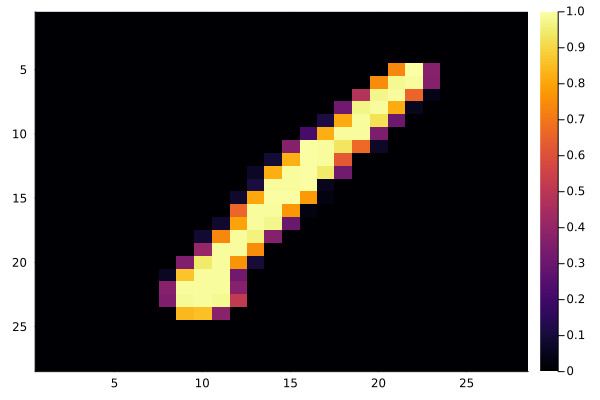

In [3]:
using Plots
function drawImage(img)
    heatmap(reshape(img, (28, 28))', yflip = true)
end

drawImage(image[1])

In [ ]:
sigmoid(x::Vector{Float64}) = 1 / (1 + exp(-x))
sigmoid_(x::Vector{Float64}) = sigmoid(x) .* (1 .- sigmoid(x))

mae(y::Vector{Float64}, ŷ::Vector{Float64}) = sum((y - ŷ) .^ 2)
mae_(y::Vector{Float64}, ŷ::Vector{Float64}) = 2 .* (y - ŷ)

crossEntropy(y::Vector{Float64}, ŷ::Vector{Float64}) = -sum(ŷ .* log.(y)) - sum((1 .- ŷ) .* log.(1 .- y))


mutable struct NeuralNetwork
    weights::Vector{Matrix{Float64}}
    bias::Vector{Vector{Float64}}
    learnRate::Float64
    batchSize::Int
    activation::Function
    activation_::Function
    loss::Function
    loss_::Function
    NeuralNetwork(args...; activation=(sigmoid, sigmoid_), loss=(mae, mae_), learnrate=0.01, batchsize=4, kwargs...) = new(
        [randn(args[i+1], args[i]) for i in 1:(length(args) - 1)],
        [randn(args[i+1]) for i in 1:(length(args) - 1)],
        kwargs[:learnrate],
        kwargs[:batchsize],
        kwargs[:activation][1],
        kwargs[:activation][2],
        kwargs[:loss][1],
        kwargs[:loss][2]
    )
end

"Get the input and output of each layer with given a single input data"
function predict(model::NeuralNetwork, data::Vector{Float64})
    ans = [(nothing, data)]
    for i in length(model.bias)
        before = weight[i] * ans[end][2] + bias[i]
        push!(ans, (before, model.activation.(before)))
    end
    return ans
end

apply(model::NeuralNetwork, data::Vector{Float64}) = predict(model, data)[end][2]

"Get the input and output of each layer with given a batch of input data"
function predict(model::NeuralNetwork, data::Vector{Vector{Float64}})
    # TODO
end

In [3]:
const inputLayerSize = 784
const hiddenLayer1Size = 20
const hiddenLayer2Size = 20
const outputLayerSize = 10

W12 = randn((hiddenLayer1Size, inputLayerSize))
W23 = randn((hiddenLayer2Size, hiddenLayer1Size))
W34 = randn((outputLayerSize, hiddenLayer2Size))
bias12 = randn(hiddenLayer1Size)
bias23 = randn(hiddenLayer2Size)
bias34 = randn(outputLayerSize)

activation(x) = 1 / (1 + exp(-x))
activation_(x) = activation(x) * (1 - activation(x))

function predict(input)
    hidden1Before = W12 * input + bias12
    hidden1After = activation.(hidden1Before)
    hidden2Before = W23 * hidden1After + bias23
    hidden2After = activation.(hidden2Before)
    outputBefore = W34 * hidden2After + bias34
    outputAfter = activation.(outputBefore)
    return (input, (hidden1Before, hidden1After), (hidden2Before, hidden2After), (outputBefore, outputAfter))
end

function onehot(value)
    arraySize = 10
    return [convert(Float64, i == (value + 1)) for i in 1:arraySize]
end

error(answer, expected) = sum((answer - expected) .^ 2)
error_(answer, expected) = 2 * (answer - expected)

imageID = 1
println("Prediction of image #$imageID is: $(predict(image[imageID])[4][2])")
println("Expected answer of image #$imageID is: $(onehot(label[imageID]))")
println("Error of prediction: $(error(predict(image[imageID])[4][2], onehot(label[imageID])))")
println("Derivative of error is: $(error_(predict(image[imageID])[4][2], onehot(label[imageID])))")

Prediction of image #1 is: [0.9990985047039084, 0.05434141163240992, 0.02001460670943122, 0.003843384108695712, 0.556933954842282, 0.768687013649834, 0.8619179021997305, 0.8894057916654953, 0.4485961079113762, 0.14507064036567813]
Expected answer of image #1 is: [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Error of prediction: 4.550167590058128
Derivative of error is: [1.9981970094078167, -1.8913171767351802, 0.04002921341886244, 0.007686768217391424, 1.113867909684564, 1.537374027299668, 1.723835804399461, 1.7788115833309905, 0.8971922158227524, 0.29014128073135625]


prediction before: [0.9991441351755789, 0.06701311660364037, 0.019650826031836748, 0.004398212180864095, 0.48265988591037884, 0.7168887527357256, 0.8061200322536486, 0.8875920519236653, 0.4002169145836814, 0.13767782887010382]
prediction after: [0.9991594795990081, 0.07206562917966516, 0.019605301536590028, 0.004593322820706577, 0.46237596724010877, 0.699906621976487, 0.7832713587201278, 0.8877158529092699, 0.3876805834722262, 0.13636093535680532]


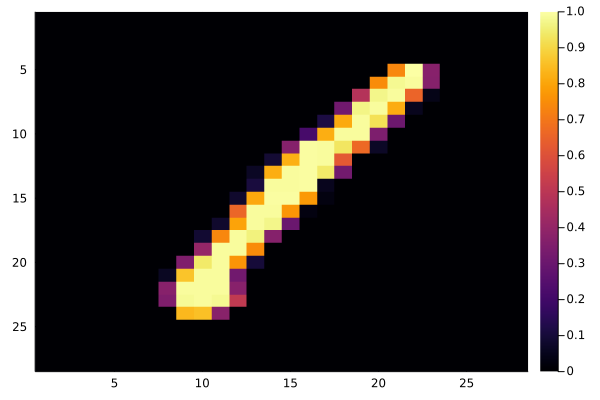

In [8]:
const η = 0.01    # learning rate

function backPropagate(predicted, expected)
    global W12, W23, W34, bias12, bias23, bias34
    # partial derivative wrt. nodes
    output_ = error_(predicted[4][2], expected)
    hidden2_ = W34' * (output_ .* activation_.(predicted[4][1]))
    hidden1_ = W23' * (hidden2_ .* activation_.(predicted[3][1]))
    # partial derivative wrt. weights and biases
    bias34_ = output_ .* activation_.(predicted[4][1])
    bias23_ = hidden2_ .* activation_.(predicted[3][1])
    bias12_ = hidden1_ .* activation_.(predicted[2][1])
    W34_ = bias34_ * predicted[3][2]'
    W23_ = bias23_ * predicted[2][2]'
    W12_ = bias12_ * predicted[1]'
    # update
    bias34 -= η * bias34_
    bias23 -= η * bias23_
    bias12 -= η * bias12_
    W34 -= η * W34_
    W23 -= η * W23_
    W12 -= η * W12_
end

println("prediction before: $(predict(image[imageID])[4][2])")
backPropagate(predict(image[imageID]), onehot(label[imageID]))
println("prediction after: $(predict(image[imageID])[4][2])")
drawImage(image[imageID])

In [10]:
function trainDNN(number)
    for i in 1:number
        index = rand(1:length(image))
        for j in 1:5
            backPropagate(predict(image[index]), onehot(label[index]))
        end
    end
end

@time trainDNN(100000)

112.058089 seconds (30.30 M allocations: 184.982 GiB, 13.14% gc time)


In [11]:
test = CSV.read("test.csv", DataFrame)
testImage = [collect(values(test[i, :])) / 255 for i in 1:size(test)[1]]

28000-element Vector{Vector{Float64}}:
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0,

[0.9977942576434066, 5.5571315720275306e-6, 1.2052211176302925e-5, 0.00017371184621706227, 3.123240320709216e-7, 0.01619143683588592, 0.0018527877081599628, 0.0004220134748513452, 5.488219417677635e-5, 0.00048811689241241363]


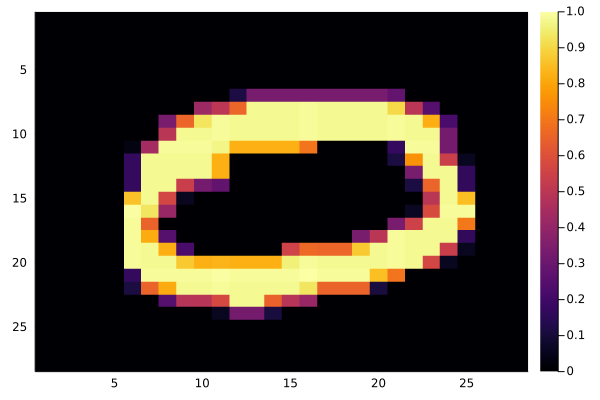

In [12]:
println(predict(testImage[2])[4][2])
drawImage(testImage[2])